In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

(900, 900, 3)


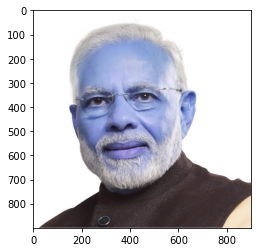

In [2]:
img=cv2.imread('./test_images/narendra_modi1.jpg')
print(img.shape)
plt.imshow(img)

(900, 900)


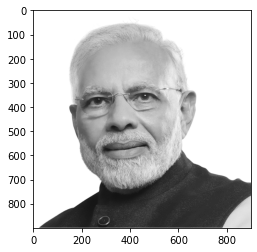

In [3]:
gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray_img.shape)
plt.imshow(gray_img,cmap='gray')

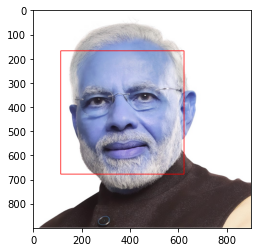

In [4]:
face_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces=face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)
faces

x,y,w,h=faces[0]
face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.figure()
plt.imshow(face_img)

278 126 131 131
102 165 96 96
148 165 86 86


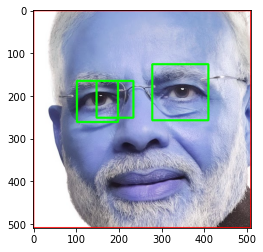

In [5]:
cv2.destroyAllWindows()
crop_img=0
for (x,y,w,h) in faces:
    face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
    roi_gray=gray_img[y:y+h,x:x+w]
    roi_color=face_img[y:y+h,x:x+w]
    eyes=eye_cascade.detectMultiScale(roi_gray)
    for(ex,ey,ew,eh) in eyes:
        print(ex,ey,ew,eh)
        crop_img=cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)
        
plt.figure()
# plt.imshow(face_img,cmap='gray')
# plt.imshow(roi_gray,cmap='gray')
# plt.imshow(roi_color,cmap='gray')
plt.imshow(crop_img,cmap='gray')
plt.show()

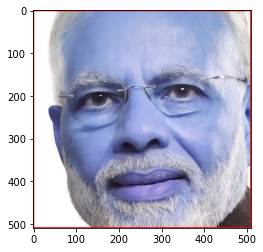

In [11]:
def getCroppedImageWith2Eyes(img_path):
    img=cv2.imread(img_path)
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray_img,1.3,5)
    for (x,y,w,h) in faces:
        face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
        roi_gray=gray_img[y:y+h,x:x+w]
        roi_color=face_img[y:y+h,x:x+w]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color

cropped_img=getCroppedImageWith2Eyes('./test_images/narendra_modi1.jpg')
# cropped_img=getCroppedImageWith2Eyes('./test_images/narendra_modi2.jpg')
if cropped_img is not None:
    plt.imshow(cropped_img)
else:
    print("2 eyes are not clearly visible")

In [7]:
import os
import shutil

path_image_data='./image_dataset/'
path_cropped_image_data='./cropped_image_dataset/'

img_dirs=[]

for entry in os.scandir(path_image_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
print(img_dirs)

if os.path.exists(path_cropped_image_data):
    shutil.rmtree(path_cropped_image_data)
os.mkdir(path_cropped_image_data)


['./image_dataset/Joe Biden', './image_dataset/Narendra Modi', './image_dataset/Putin', './image_dataset/Shehbaz Sharif', './image_dataset/Xi Jinping']


In [8]:
cropped_img_dirs=[]
primeministers_file_names_dict={}

for img_dir in img_dirs:
    count=1
    pm_name=img_dir.split('/')[-1]
    print(pm_name)
    
    primeministers_file_names_dict[pm_name]=[]
        
    for entry in os.scandir(img_dir):
#       print(entry.path,"\n")
        cropped_img=getCroppedImageWith2Eyes(entry.path)
        if cropped_img is not None:
            cropped_folder=path_cropped_image_data+pm_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generating cropped images in folder : ",cropped_folder)
                
            cropped_file_name=pm_name+str(count)+".png"
            cropped_file_path=cropped_folder+"/"+cropped_file_name
            
            cv2.imwrite(cropped_file_path,cropped_img)
            primeministers_file_names_dict[pm_name].append(cropped_file_path)
            count=count+1
    
print("\nFinished")
    

Joe Biden
Generating cropped images in folder :  ./cropped_image_dataset/Joe Biden
Narendra Modi
Generating cropped images in folder :  ./cropped_image_dataset/Narendra Modi
Putin
Generating cropped images in folder :  ./cropped_image_dataset/Putin
Shehbaz Sharif
Generating cropped images in folder :  ./cropped_image_dataset/Shehbaz Sharif
Xi Jinping
Generating cropped images in folder :  ./cropped_image_dataset/Xi Jinping

Finished


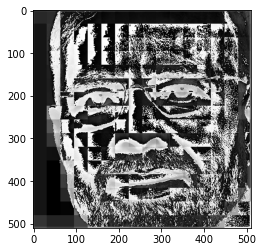

In [12]:
import pywt

def w2d(img,mode='haar',level=1):
    imArray=img
    imArray=cv2.cvtColor(imArray,cv2.COLOR_BGR2GRAY)
    imArray=np.float32(imArray)
    imArray/=255
    
    #compute coefficients
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    
    #process coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    
    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)
    
    return imArray_H

im_har=w2d(cropped_img,'db1',5)
plt.imshow(im_har,cmap='gray')

In [13]:
class_dict={}
count=0
for pm_name in primeministers_file_names_dict.keys():
    class_dict[pm_name]=count
    count=count+1
print(class_dict)

{'Joe Biden': 0, 'Narendra Modi': 1, 'Putin': 2, 'Shehbaz Sharif': 3, 'Xi Jinping': 4}


In [14]:
# primeministers_file_names_dict2=primeministers_file_names_dict
# print(primeministers_file_names_dict2)

X=[]
Y=[]

for pm_name,training_files in primeministers_file_names_dict.items():
    for training_img in training_files:
        img=cv2.imread(training_img)
        if img is not None:
            scalled_img=cv2.resize(img,(32,32))
            img_har=w2d(img,'db1',5)
            scalled_img_har=cv2.resize(img_har,(32,32))
            combined_img=np.vstack((scalled_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            Y.append(class_dict[pm_name])
            
X=np.array(X)
Y=np.array(Y)
print(X.shape)
print(Y.shape)

X=X.reshape(len(X),4096).astype(float)
print(X.shape)

(203, 4096, 1)
(203,)
(203, 4096)


In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report

In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=53)
pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,Y_train)
print(pipe.score(X_test,Y_test),"\n")
print(classification_report(Y_test,pipe.predict(X_test)))

0.8431372549019608 

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      1.00      1.00         4
           2       1.00      0.20      0.33         5
           3       0.83      1.00      0.91        25
           4       1.00      0.69      0.82        13

    accuracy                           0.84        51
   macro avg       0.88      0.78      0.76        51
weighted avg       0.88      0.84      0.82        51



In [17]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params={
    'svm':{
        'model':svm.SVC(gamma='auto',probability=True),
        'params':{
            'svc__C':[1,10,100,1000],
            'svc__kernel':['rbf','linear']
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[1,5,10]
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(solver='liblinear',multi_class='auto'),
        'params':{
            'logisticregression__C':[1,5,10]
        }
    }
}


In [23]:
import pandas as pd

scores=[]
best_estimators={}
for algo,mp in model_params.items():
    pipe=make_pipeline(StandardScaler(),mp['model'])
    clf=GridSearchCV(pipe,mp['params'],cv=5,return_train_score=False)
    clf.fit(X_train,Y_train)
    scores.append({
        'model':algo,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[algo]=clf.best_estimator_

df=pd.DataFrame(scores,columns=['model','best_score','best_params'])
print(df)

print("\n\nSVM : ",best_estimators['svm'].score(X_test,Y_test))
print("Random Forest : ",best_estimators['random_forest'].score(X_test,Y_test))
print("Logistic Regression : ",best_estimators['logistic_regression'].score(X_test,Y_test))

                 model  best_score  \
0                  svm    0.842796   
1        random_forest    0.592473   
2  logistic_regression    0.823226   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}  


SVM :  0.9215686274509803
Random Forest :  0.7058823529411765
Logistic Regression :  0.9019607843137255


Text(24.0, 0.5, 'Actual\n')

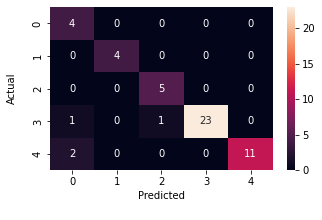

In [28]:
import seaborn as sn
best_clf=best_estimators['svm']
cm=confusion_matrix(Y_test,best_clf.predict(X_test))
plt.figure(figsize=(5,3))
sn.heatmap(cm,annot=True)
plt.xlabel("Predicted\n")
plt.ylabel("Actual\n")

In [31]:
import joblib
import json

joblib.dump(best_clf,'PrimeMinistersClassifierModel.pkl')
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))